### Import

In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
from pathlib import Path
import math
import random
import librosa.display
import shutil

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Load Data

In [2]:
#load meta_data
df=pd.read_csv('/Users/christian/Desktop/GA/public_dataset.nosync/metadata_compiled.csv')

In [3]:
#examine the columns in the metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27550 entries, 0 to 27549
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   27550 non-null  object 
 1   datetime               27550 non-null  object 
 2   cough_detected         27550 non-null  float64
 3   SNR                    27550 non-null  float64
 4   latitude               16084 non-null  float64
 5   longitude              16084 non-null  float64
 6   age                    15218 non-null  float64
 7   gender                 16224 non-null  object 
 8   respiratory_condition  16224 non-null  object 
 9   fever_muscle_pain      16224 non-null  object 
 10  status                 16224 non-null  object 
 11  quality_1              820 non-null    object 
 12  cough_type_1           802 non-null    object 
 13  dyspnea_1              820 non-null    object 
 14  wheezing_1             820 non-null    object 
 15  st

For this project I will be focusing on using the audio feautures extracted from the audio files as predictors so most of the columns will not be used.

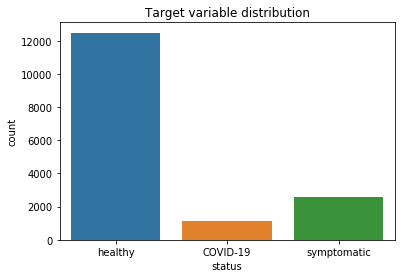

In [4]:
#target variable, COVID-19 status distribution
sns.countplot(x=df.status)
plt.title('Target variable distribution')
plt.show()

As is stands using the full dataset would mean I would have imbalanced classes and I would have to address this accorindly. However I am going to subset on the data further and so will address this issue if it is still present.

### Subset Data

I am proceeding with only the samples that have been analysed by expert pulmonologists. This is because these defintiely have been confirmed to either have cough present in the sample or not. I will drop the samples with no cough present.

Some of the samples as shown above are labelled 'symptomatic' - they show signs of COVID-19 but are not confirmed positive. As these cases are not confirmed positive I will be dropping them from the data.



In [5]:
#subset on coughs examined by expert pulmonologists
df=df[df.quality_1.notnull() | df.quality_2.notnull() | df.quality_3.notnull()| df.quality_4.notnull()]

#drop samples with a cough_detected score of 0
df=df[df.cough_detected!=0]

#only keep samples that are either healthy or are postive for COVID-19
df=df[(df.status=='healthy') | (df.status=='COVID-19')]

#reset the index after subsetting
df=df.reset_index(drop=True)

In [6]:
df.shape

(1465, 51)

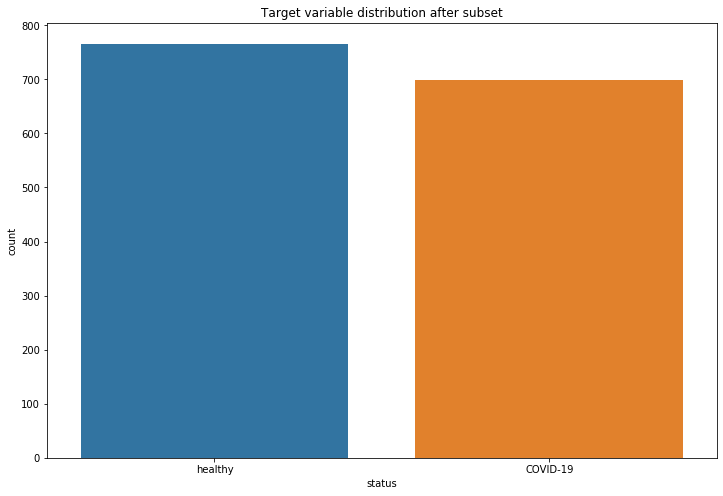

In [7]:
plt.figure(figsize=(12,8))
sns.countplot(x=df.status)
plt.title('Target variable distribution after subset')
plt.show()

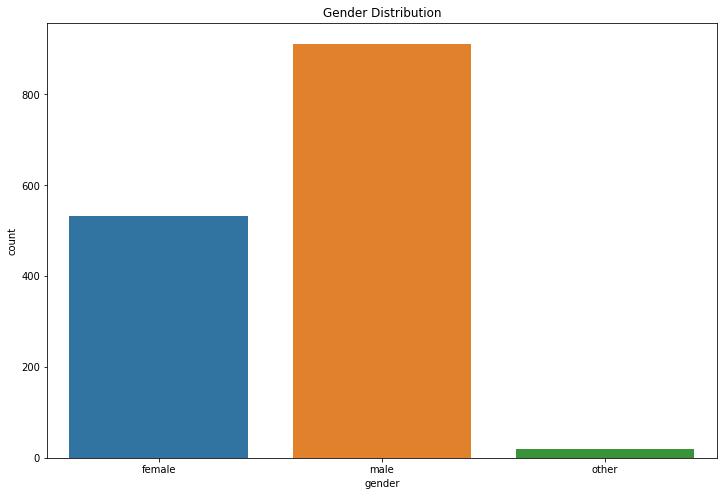

In [9]:
#gender distribution
plt.figure(figsize=(12,8))
sns.countplot(x=df.gender)
plt.title('Gender Distribution');

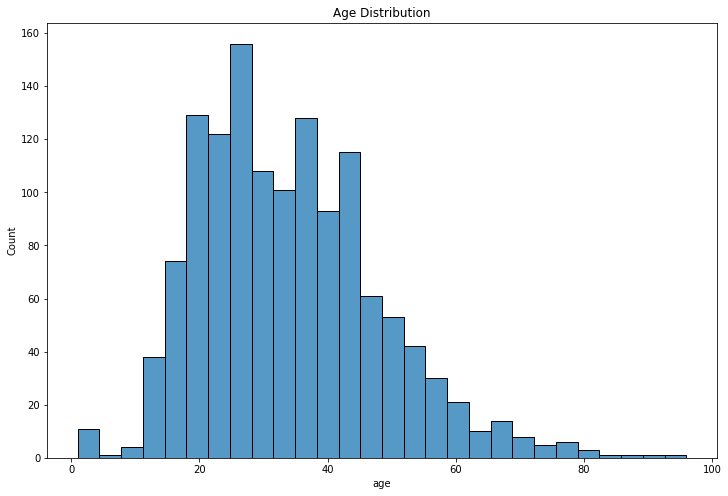

In [10]:
#Age Distribution
plt.figure(figsize=(12,8))
sns.histplot(df.age)
plt.title('Age Distribution')
plt.show()

### Copy and Convert Files to Wav

I will use the functions below to relocate the files and convert them to wav format. The relavant audio files can be identified by their 'uuid' in the dataframe which is the same as the filename.

In [11]:
# copy files to seperate directory
def copy_files(folder, names_to_copy, target_folder):
    """Copy select files to chosen directory

    folder:        path to coughvid database and metadata_compiled csv
    names_to_copy: filenames to copy
    target_folder: target directory  """

    for counter, name in enumerate(names_to_copy):

        if os.path.isfile(folder + name + '.webm'):

            original = folder + name + '.webm'
            target = target_folder + name + '.webm'

        elif os.path.isfile(folder + name + '.ogg'):

            original = folder + name + '.ogg'
            target = target_folder + name + '.ogg'

        else:

            print("Error: No file name {0}".format(name))
            continue
            
        shutil.copyfile(original, target)

In [16]:
copy_files('../../../../public_dataset.nosync/',df.uuid,'coughvid_subset/')

In [12]:
# Convert files to WAV
def convert_files(folder, names_to_convert):
    """Convert files from .webm and .ogg to .wav

    folder: path to audio files
    names_to_convert: filenames to convert"""

    # loop through list of names
    for counter, name in enumerate(names_to_convert):

        # print progress every 500 files
        if (counter % 500 == 0):
            print("Finished {0}/{1}".format(counter, len(names_to_convert)))

        # if wav file already exists continue
        if os.path.isfile(folder + name + '.wav'):
            continue

        # else convert to wav
        else:

            if os.path.isfile(folder + name + '.webm'):
                subprocess.call(
                    ["ffmpeg", "-i", folder+name+".webm", folder+name+".wav"])

            elif os.path.isfile(folder + name + '.ogg'):
                subprocess.call(
                    ["ffmpeg", "-i", folder+name+".ogg", folder+name+".wav"])
                
            elif os.path.isfile(folder + name + '.m4a'):
                subprocess.call(
                    ["ffmpeg", "-i", folder+name+".m4a", folder+name+".wav"])

            else:
                print("Error: No file name {0}".format(name))

In [17]:
convert_files('coughvid_subset/',df.uuid)

Finished 0/1465
Finished 500/1465
Finished 1000/1465


Having subsetted the dataset and converted the relavent audio samples I will now carry out the sample segmentation and feature extraction in the next notebook

In [14]:
df.to_csv('df.csv',index=False)